# Outlier Detection for Audit Sampling

This notebook demonstrates outlier detection using Z-scores on the `time_to_payment` feature from the `payments_master.csv` dataset. The goal is to identify statistical outliers that could be flagged for further investigation in an audit sampling process.


In [1]:
import os
import pandas as pd
import numpy as np
from scipy.stats import zscore

## 1. Data Loading and Preparation

We load the `payments_master.csv` dataset, convert relevant date columns to datetime objects, and calculate the `time_to_payment` in days. Rows with missing `time_to_payment` values are dropped to ensure accurate Z-score calculation.


In [2]:
cwd = os.getcwd()
data_dir = os.path.join(cwd, 'data')
print(f"Data directory is set to: {data_dir}")

payment_master_path = os.path.join(data_dir, 'payments_master.csv')
fraud_case_master_path = os.path.join(data_dir, 'fraud_case_master.csv')
research_team_master_path = os.path.join(data_dir, 'research_team_master.csv')
research_team_member_master_path = os.path.join(data_dir, 'research_team_member_master.csv')
print("************************\n")
print(f"Payment master path: {payment_master_path}")
print(f"Fraud case master path: {fraud_case_master_path}")
print(f"Research team master path: {research_team_master_path}")
print(f"Research team member master path: {research_team_member_master_path}")

Data directory is set to: c:\Users\homep\Documents\Projects\bupa_case_study\data
************************

Payment master path: c:\Users\homep\Documents\Projects\bupa_case_study\data\payments_master.csv
Fraud case master path: c:\Users\homep\Documents\Projects\bupa_case_study\data\fraud_case_master.csv
Research team master path: c:\Users\homep\Documents\Projects\bupa_case_study\data\research_team_master.csv
Research team member master path: c:\Users\homep\Documents\Projects\bupa_case_study\data\research_team_member_master.csv


In [3]:
# Load the dataset
try:
    df = pd.read_csv(payment_master_path)
except FileNotFoundError:
    print("Error: payments_master.csv not found. Please ensure the file is in the correct directory.")
    exit()

# Convert date columns to datetime objects
date_cols = ['Date received', 'Date of payment']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Calculate 'time to payment' in days
df['time_to_payment'] = (df['Date of payment'] - df['Date received']).dt.days

# Drop rows where 'time_to_payment' is NaN
df.dropna(subset=['time_to_payment'], inplace=True)

print(f"Dataset loaded with {len(df)} records after dropping rows with missing time_to_payment.")
print(df.head())


Dataset loaded with 1428 records after dropping rows with missing time_to_payment.
  Date received Research team        Submitted by Date of invoice  \
0    2025-04-27      Genetics       Melinda White      2025-04-14   
1    2025-06-02    Immunology     Daniel Peterson      2025-05-28   
3    2025-04-10      Oncology  Christopher Wilson      2025-03-27   
4    2025-05-18    Immunology      Amanda Johnson      2025-05-11   
5    2025-02-02    Immunology        Austin Terry      2025-01-22   

  Invoice number                               Description of spend  \
0      INV-76915  "Procured DNA extraction kits for isolating hi...   
1      INV-64102  "Purchase of endotoxin-free reagents for in vi...   
3      INV-20676  "Procured RNA extraction kits for high-through...   
4      INV-49709  "Purchased Luminex multiplex assay kits for si...   
5      INV-95698  "Procured reagents for intracellular cytokine ...   

   Invoice value Date of authorisation     Authorised by Payment due date  

## 2. Z-score Calculation and Outlier Identification

We calculate the absolute Z-score for each `time_to_payment` value. The Z-score measures how many standard deviations away from the mean a data point is. A common threshold for identifying outliers is a Z-score greater than 3. We then filter the dataset to show only the identified outliers.


Identified 0 outliers in 'time_to_payment' using a Z-score threshold of 3.
Total records: 1428
Percentage of outliers: 0.00%

Summary of time_to_payment:
count    1428.000000
mean       18.469888
std         7.273981
min         2.000000
25%        13.000000
50%        19.000000
75%        24.000000
max        35.000000

Outliers detected (first 10 rows):
Empty DataFrame
Columns: [Invoice number, Date received, Date of payment, time_to_payment, zscore_time_to_payment]
Index: []


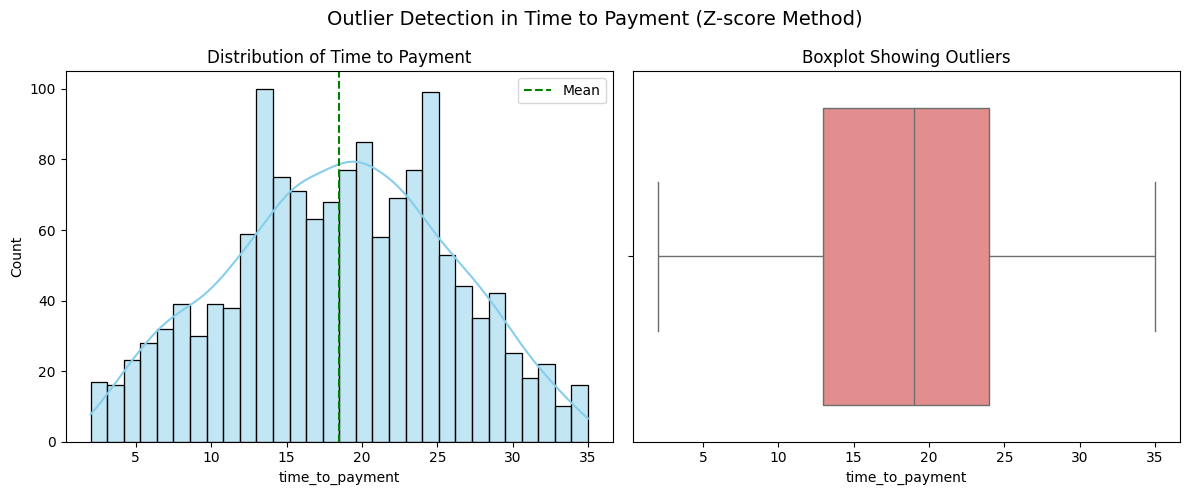

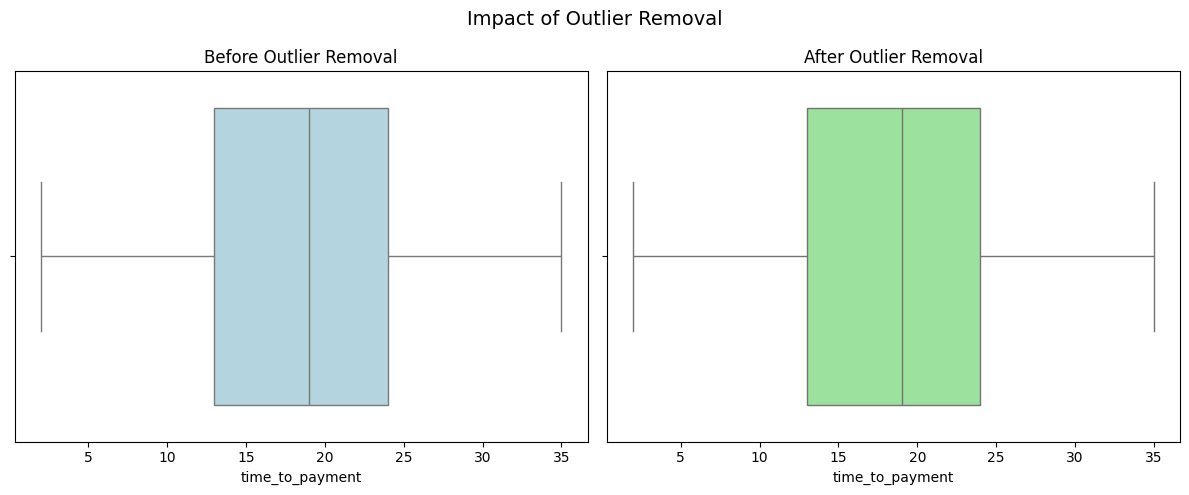

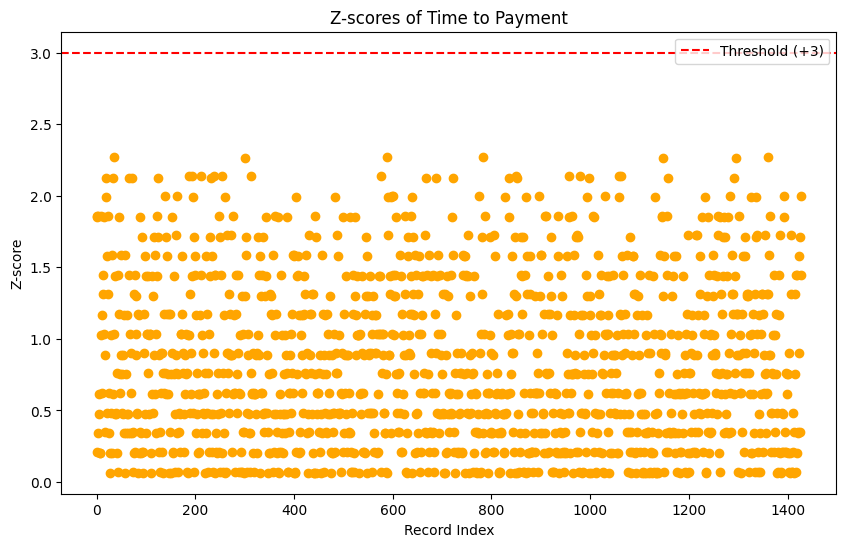

In [11]:
# # Calculate Z-scores for 'time_to_payment'
# df['zscore_time_to_payment'] = np.abs(zscore(df['time_to_payment']))

# # Define a threshold for outliers (e.g., Z-score > 3)
# threshold = 2

# # Identify outliers
# outliers = df[df['zscore_time_to_payment'] > threshold]

# print(f"Identified {len(outliers)} outliers in 'time to payment' using a Z-score threshold of {threshold}.")
# print("\nOutliers detected (first 10 rows):")
# print(outliers[['Invoice number', 'Date received', 'Date of payment', 'time_to_payment', 'zscore_time_to_payment']].head(10))


import matplotlib.pyplot as plt
import seaborn as sns

# Calculate Z-scores for 'time_to_payment'
df['zscore_time_to_payment'] = np.abs(zscore(df['time_to_payment']))

# Define a threshold for outliers (e.g., Z-score > 2)
threshold = 3

# Identify outliers and clean data
outliers = df[df['zscore_time_to_payment'] > threshold]
clean_df = df[df['zscore_time_to_payment'] <= threshold]

# ---- Summary statistics ----
print(f"Identified {len(outliers)} outliers in 'time_to_payment' using a Z-score threshold of {threshold}.")
print(f"Total records: {len(df)}")
print(f"Percentage of outliers: {len(outliers) / len(df) * 100:.2f}%\n")

print("Summary of time_to_payment:")
print(df['time_to_payment'].describe().to_string())
print("\nOutliers detected (first 10 rows):")
print(outliers[['Invoice number', 'Date received', 'Date of payment', 'time_to_payment', 'zscore_time_to_payment']].head(10))

# ---- Visualization section ----
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogram with KDE and mean line
sns.histplot(df['time_to_payment'], bins=30, kde=True, color='skyblue', ax=axes[0])
axes[0].axvline(df['time_to_payment'].mean(), color='green', linestyle='--', label='Mean')
axes[0].set_title('Distribution of Time to Payment')
axes[0].legend()

# Boxplot before and after outlier removal
sns.boxplot(x=df['time_to_payment'], color='lightcoral', ax=axes[1])
axes[1].set_title('Boxplot Showing Outliers')

plt.suptitle('Outlier Detection in Time to Payment (Z-score Method)', fontsize=14)
plt.tight_layout()
plt.show()

# ---- Before vs After Comparison ----
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(x=df['time_to_payment'], ax=axes[0], color='lightblue')
axes[0].set_title('Before Outlier Removal')
sns.boxplot(x=clean_df['time_to_payment'], ax=axes[1], color='lightgreen')
axes[1].set_title('After Outlier Removal')
plt.suptitle('Impact of Outlier Removal', fontsize=14)
plt.tight_layout()
plt.show()

# ---- Z-score scatter plot ----
plt.figure(figsize=(10,6))
plt.scatter(range(len(df)), df['zscore_time_to_payment'], color='orange')
plt.axhline(threshold, color='red', linestyle='--', label=f'Threshold (+{threshold})')
plt.title('Z-scores of Time to Payment')
plt.xlabel('Record Index')
plt.ylabel('Z-score')
plt.legend()
plt.show()

